# Análise da base de dados por meio do algoritmo k-Nearest Neighbors (kNN)

## Bibliotecas necessárias

In [137]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error, root_mean_squared_error
from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import KFold

# Carregando a base de dados numa planilha do Google Sheets

In [138]:
url = r"https://docs.google.com/spreadsheets/d/e/2PACX-1vTSEtC2uCzOX9-5zgkIkuqyZA51Z5nGlem0Y5w6kbLPcmzENBe0yujL9WAGBDgT9y7VBQniOlMg4Baf/pub?output=csv"

insta_df = pd.read_csv(url)

insta_df.head()

,rank,channel_info,influence_score,posts,followers,avg_likes,60_day_eng_rate,new_post_avg_like,total_likes,country
0,1,cristiano,92,3.3k,475.8m,8.7m,1.39%,6.5m,29.0b,Spain
1,2,kyliejenner,91,6.9k,366.2m,8.3m,1.62%,5.9m,57.4b,United States
2,3,leomessi,90,0.89k,357.3m,6.8m,1.24%,4.4m,6.0b,NaN
3,4,selenagomez,93,1.8k,342.7m,6.2m,0.97%,3.3m,11.5b,United States
4,5,therock,91,6.8k,334.1m,1.9m,0.20%,665.3k,12.5b,United States


# Conhecendo a base

In [139]:
insta_df.describe()

,rank,influence_score
count,200.000000,200.000000
mean,100.500000,81.820000
std,57.879185,8.878159
min,1.000000,22.000000
25%,50.750000,80.000000
50%,100.500000,84.000000
75%,150.250000,86.000000
max,200.000000,93.000000


In [140]:
insta_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   rank               200 non-null    int64 
 1   channel_info       200 non-null    object
 2   influence_score    200 non-null    int64 
 3   posts              200 non-null    object
 4   followers          200 non-null    object
 5   avg_likes          200 non-null    object
 6   60_day_eng_rate    200 non-null    object
 7   new_post_avg_like  200 non-null    object
 8   total_likes        200 non-null    object
 9   country            138 non-null    object
dtypes: int64(2), object(8)
memory usage: 15.8+ KB


In [141]:
insta_df['country'].value_counts()

country
United States             66
Brazil                    13
India                     12
Indonesia                  7
France                     6
Spain                      5
United Kingdom             4
Colombia                   3
Canada                     3
Mexico                     2
Turkey                     2
Netherlands                2
Switzerland                1
Germany                    1
Czech Republic             1
British Virgin Islands     1
Sweden                     1
Australia                  1
Anguilla                   1
CÃ´te d'Ivoire             1
Puerto Rico                1
United Arab Emirates       1
Italy                      1
Uruguay                    1
Russia                     1
Name: count, dtype: int64

# Tratando os dados

## Convertendo os sufixos das colunas que seriam numéricas

In [142]:
# Função para converter valores com sufixos 'b', 'm' e 'k' para int
def converter_sufixo(valor):
    if isinstance(valor, str):
        if 'b' in valor:
            return int(float(valor.replace('b', '')) * 1e9)
        elif 'm' in valor:
            return int(float(valor.replace('m', '')) * 1e6)
        elif 'k' in valor:
            return int(float(valor.replace('k', '')) * 1e3)
    return valor

colunas_num = ['posts', 'followers', 'avg_likes', 'new_post_avg_like', 'total_likes']

# Aplicar a função nas colunas
for col in colunas_num:
    insta_df[col] = insta_df[col].apply(converter_sufixo)

# Transformar em int64
for col in colunas_num:
    insta_df[col] = insta_df[col].astype(np.int64)

insta_df.head(3)

,rank,channel_info,influence_score,posts,followers,avg_likes,60_day_eng_rate,new_post_avg_like,total_likes,country
0,1,cristiano,92,3300,475800000,8700000,1.39%,6500000,29000000000,Spain
1,2,kyliejenner,91,6900,366200000,8300000,1.62%,5900000,57400000000,United States
2,3,leomessi,90,890,357300000,6800000,1.24%,4400000,6000000000,NaN


## Retirando o '%' da coluna 60_day_eng_rate

In [143]:
# Função para remover '%' e dividir por 100
def converter_percentual(valor):
    if isinstance(valor, str) and '%' in valor:
        return float(valor.replace('%', '')) / 100
    return valor

insta_df['60_day_eng_rate'] = insta_df['60_day_eng_rate'].apply(converter_percentual)
insta_df['60_day_eng_rate'] = insta_df['60_day_eng_rate'].astype(np.float64)

insta_df.head(3)

,rank,channel_info,influence_score,posts,followers,avg_likes,60_day_eng_rate,new_post_avg_like,total_likes,country
0,1,cristiano,92,3300,475800000,8700000,0.0139,6500000,29000000000,Spain
1,2,kyliejenner,91,6900,366200000,8300000,0.0162,5900000,57400000000,United States
2,3,leomessi,90,890,357300000,6800000,0.0124,4400000,6000000000,NaN


## Mapear os continentes para cada país

In [144]:
mapa_continentes = {'Brazil': 1, 
                    'Uruguay': 2,  
                    'Colombia': 3,
                    'British Virgin Islands': 10,
                    'Puerto Rico': 11,
                    'Anguilla': 12,
                    'Mexico': 20, 
                    'United States': 21,
                    'Canada': 22,  
                    'Germany': 40, 
                    'France': 41, 
                    'United Kingdom': 42,
                    'Russia': 43,
                    'Italy': 44, 
                    'Sweden': 45,
                    'Netherlands': 46,
                    'Czech Republic': 47,
                    'Switzerland': 48,
                    'Spain': 49,
                    'Turkey': 50,  
                    'India': 60, 
                    'United Arab Emirates': 61,
                    "CÃ´te d'Ivoire": 70,
                    'Indonesia': 80,
                    'Australia': 100}

# Função para mapear países a continentes
def mapear_continente(pais):
    return mapa_continentes.get(pais, None)

# Aplicar a função na coluna 'country'
insta_df['continent_code'] = insta_df['country'].apply(mapear_continente)

insta_df.tail()


,rank,channel_info,influence_score,posts,followers,avg_likes,60_day_eng_rate,new_post_avg_like,total_likes,country,continent_code
195,196,iambeckyg,71,2300,33200000,623800,0.0140,464700,1400000000,United States,21.0
196,197,nancyajram,81,3800,33200000,390400,0.0064,208000,1500000000,France,41.0
197,198,luansantana,79,770,33200000,193300,0.0026,82600,149200000,Brazil,1.0
198,199,nickjonas,78,2300,33000000,719600,0.0142,467700,1700000000,United States,21.0
199,200,raisa6690,80,4200,32799999,232200,0.0030,97400,969100000,Indonesia,80.0


Aqui o código de continente foi adicionado de modo manual, baseado numa distância linear entre continentes

# Análise exploratória

## Correlações entre variáveis

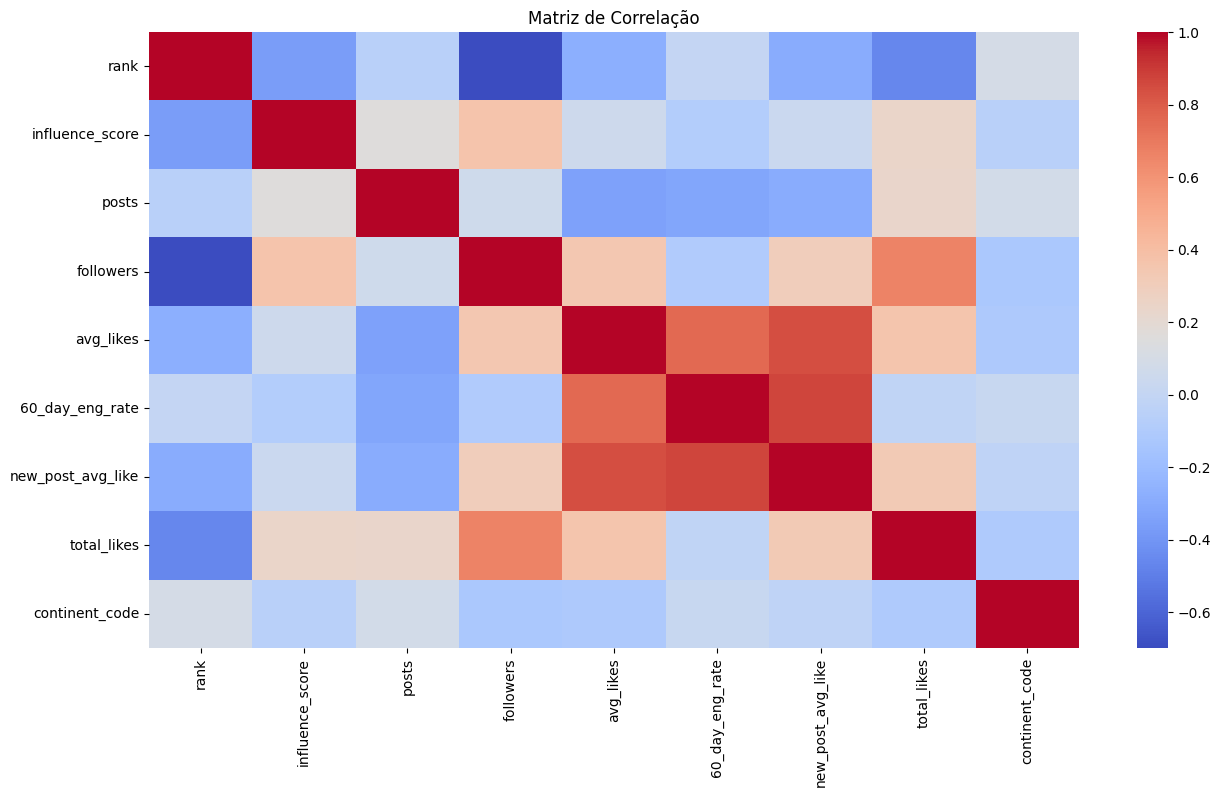

In [145]:
corr = insta_df.corr(numeric_only=True)

plt.figure(figsize=(15, 8))
sns.heatmap(corr, cmap='coolwarm', fmt='.2f')
plt.title('Matriz de Correlação')
plt.show()

### Relação entre followers e avg_likes

As colunas tem correlação positiva fraca, o que é contraintuitivo, visto que a ideia é que quanto maior a quantidade de seguidores, a média de likes cresceria na mesma proporção. Isso pode sugerir que apenas uma parcela dos novos seguidores realmente curtem os posts do influencer.

### Impacto de 60_day_eng_rate na taxa de engajamento (influence_score)

A taxa de engajamento dos últimos 60 dias apresenta correlação nula com a taxa de engajamento do influencer.
Isso pode ser explicado talvez pelo fato de que pessoas muito famosas não perdem o engajamento mesmo estando dias sem fazer um post. Essas pessoas recebem muitas curtidas independente do intervalo de tempo entre os posts.

# Preparando os dados para o modelo

In [146]:
features = ['posts', 'followers', 'avg_likes', '60_day_eng_rate', 'new_post_avg_like', 'total_likes', 'continent_code']
target = 'influence_score'

Nesse modelo está sendo considerado como target a coluna 'influence_score', para modelar a relação de como os valores das features determinam a taxa de influência do usuário.

## Apagar linhas que contenham valores NaN na coluna 'continent_code'

In [147]:
insta_df['continent_code'].isna().sum()   #Muitos dados NaN, o dataframe já possuia poucos dados, isso irá influenciar no desempenho do modelo

62

In [148]:
insta_df.dropna(inplace=True)
insta_df['continent_code'].isna().sum()

0

## Normalizando colunas numéricas para valores de 0 a 1

In [149]:
from sklearn.preprocessing import MinMaxScaler

def normalizar_colunas(df, colunas):
    """
    Função para normalizar colunas numéricas entre 0 e 1 usando MinMaxScaler.
    
    df: DataFrame a ser normalizado
    colunas: Lista de colunas a serem normalizadas
    
    Retorna o DataFrame com as colunas normalizadas.
    """
    scaler = MinMaxScaler()
    df[colunas] = scaler.fit_transform(df[colunas])
    return df

In [150]:
normalizar_colunas(insta_df, features)

insta_df.head(3)

,rank,channel_info,influence_score,posts,followers,avg_likes,60_day_eng_rate,new_post_avg_like,total_likes,country,continent_code
0,1,cristiano,92,0.187643,1.000000,1.000000,0.134766,1.000000,0.505069,Spain,0.484848
1,2,kyliejenner,91,0.393593,0.752596,0.953676,0.157227,0.907692,1.000000,United States,0.202020
3,4,selenagomez,93,0.101831,0.699549,0.710477,0.093750,0.507692,0.200093,United States,0.202020


# Criando o modelo kNN

In [151]:
def n_neighbors_visualization(df, features, target, quant_neighbors, mae=True, rmse=True):
    '''
    Função para visualizar diferentes desempenhos do algoritmo KNN para regressão com validação cruzada.
        df: DataFrame a ser utilizado
        features: Lista com as colunas do dataframe para treino e teste
        target: Nome da coluna target para previsão
        quant_neighbors: Quantidade máxima de vizinhos do KNN (K) para treinar e visualizar
        mae: Se False, oculta o erro absoluto médio da visualização (Standard = True)
        rmse: Se False, oculta a raiz do erro quadrático médio da visualização (Standard = True)
    '''
    
    mae_list = []
    rmse_list = []

    X = df[features]
    y = df[target]

    for i in range(1, quant_neighbors + 1):
        knn = KNeighborsRegressor(n_neighbors=i, n_jobs=-1)  # criando o modelo com K=i
        
        # Validação cruzada
        y_pred = cross_val_predict(knn, X, y, cv=10, n_jobs=-1)
        
        # Erro absoluto médio
        mae_val = mean_absolute_error(y, y_pred)
        mae_list.append(mae_val)
        
        # Raiz do erro quadrático médio
        rmse_val = root_mean_squared_error(y, y_pred)
        rmse_list.append(rmse_val)

    # Encontrando os melhores MAE e RMSE e os valores de K correspondentes
    best_mae = min(mae_list)
    best_k_mae = mae_list.index(best_mae) + 1
    best_rmse = min(rmse_list)
    best_k_rmse = rmse_list.index(best_rmse) + 1

    if mae:
        plt.figure(figsize=(15, 5))
        plt.plot(range(1, len(mae_list) + 1), mae_list)
        plt.xlabel('Número de vizinhos')
        plt.ylabel('Erro Absoluto Médio')
        plt.title('Erro Absoluto Médio por n° de vizinhos')

        # Adicionando os valores de MAE em cada ponto
        for i, val in enumerate(mae_list, start=1):
            plt.text(i, val, f'{val:.4f}', fontsize=9, ha='center', va='bottom')
        plt.show()
        print(f"Melhor MAE: {best_mae:.4f} com K = {best_k_mae}")

    if rmse:
        plt.figure(figsize=(15, 5))
        plt.plot(range(1, len(rmse_list) + 1), rmse_list, 'r')
        plt.xlabel('Número de vizinhos')
        plt.ylabel('Raiz do Erro Quadrático Médio')
        plt.title('Raiz do Erro Quadrático Médio por n° de vizinhos')

        # Adicionando os valores de RMSE em cada ponto
        for i, val in enumerate(rmse_list, start=1):
            plt.text(i, val, f'{val:.4f}', fontsize=9, ha='center', va='bottom')
        plt.show()
        print(f"Melhor RMSE: {best_rmse:.4f} com K = {best_k_rmse}")


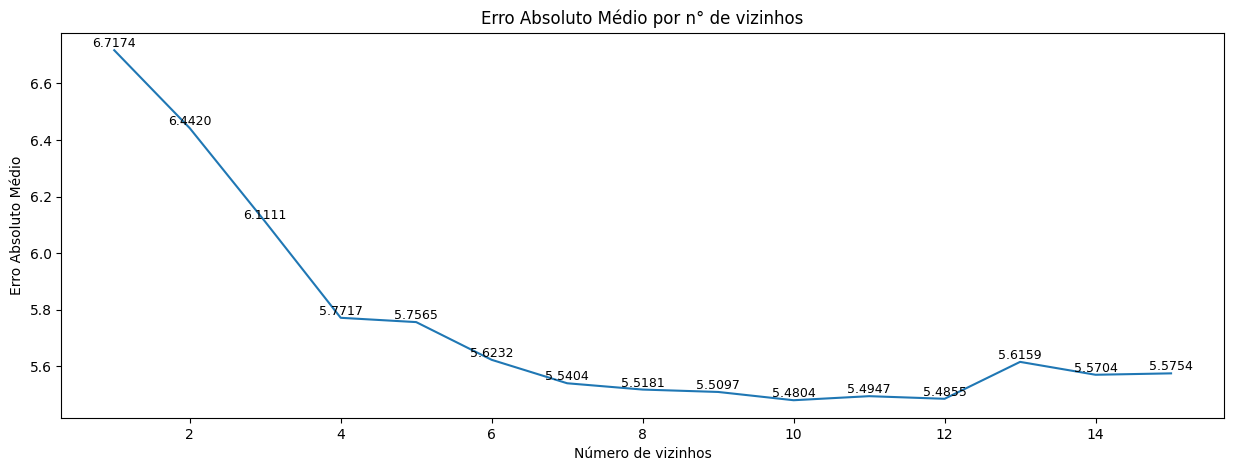

Melhor MAE: 5.4804 com K = 10


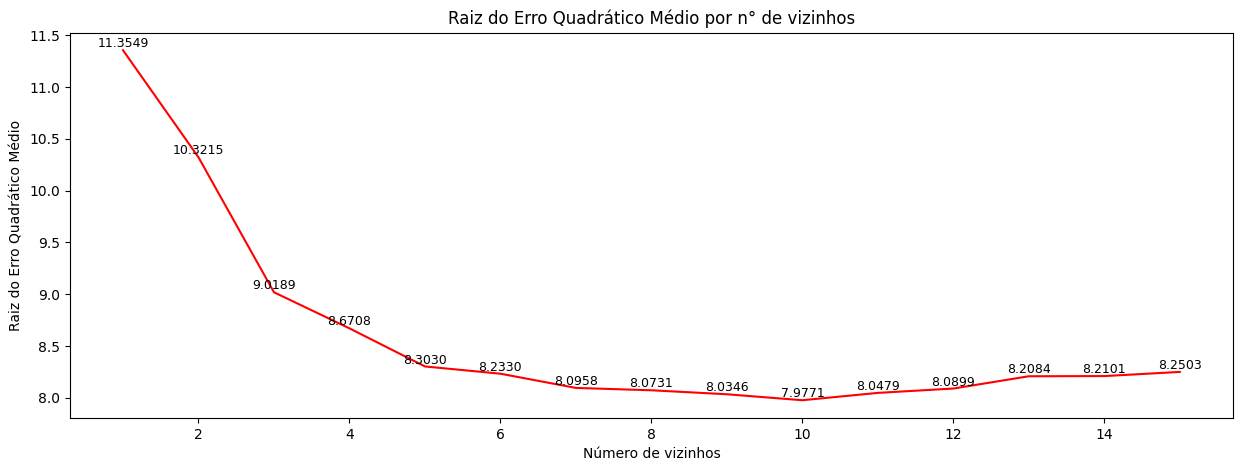

Melhor RMSE: 7.9771 com K = 10


In [152]:
n_neighbors_visualization(insta_df, features=features, target=target, quant_neighbors=15)

Nessa análise, a quantidade de vizinhos que minimizou os erros foi a de K=10.

# Aprofundamento da escolha dos hiperparâmetros com Bayesian Optimization

O modelo anterior foi testado considerando apenas os valores de K (vizinhos), mas a partir de agora o modelo vai ser rodado de maneira mais eficiente no que se trata à escolha de hiperparâmetros. O GridSearch acaba testando todas as combinações de hiperparâmetros, o que traz um alto custo computacional. No entanto, a Otimização Bayesiana testa os hiperparâmetros de forma mais inteligente, o que o torna mais eficiente e traz resultado semelhante ao GridSearch.

OBS: Essa é uma base de dados muito pequena, portanto poderíamos sem problemas aplicar o GridSearch, porém, com a justificativa de já se acostumar com uma prática melhor de Machine Learning, estaremos usando a Otimização Bayesiana.

## Função baseada na minimização do Mean Absolute Error

In [153]:
X = insta_df[features]
y = insta_df[target]

In [154]:
def treinar_knn_mae(params):
    neighbors = params[0]
    weights = params[1]
    algorithm = params[2]
    leaf_size = params[3]
    p = params[4]
    metric = params[5]

    modelo = KNeighborsRegressor(n_neighbors=neighbors, 
                                 weights=weights, 
                                 algorithm=algorithm, 
                                 leaf_size=leaf_size, 
                                 p=p, metric=metric, 
                                 n_jobs=-1)    #n_jobs=-1 utiliza toda a capacidade disponível para o modelo


    # Validação cruzada
    y_pred = cross_val_predict(modelo, X, y, cv=10, n_jobs=-1)

    mae_CV = mean_absolute_error(y, y_pred)

    return mae_CV

## Definindo o espaço de busca dos hiperparâmetros

In [155]:
from skopt.space import Categorical

space = [
    (2, 25),   # neighbors
    Categorical(['uniform', 'distance'], name='weights'),    # weights
    Categorical(['auto', 'ball_tree', 'kd_tree', 'brute'], name='algorithm'),   # algorithm
    (10, 50), # leaf_size
    (1, 2), # p
    Categorical(['minkowski', 'euclidean', 'manhattan'], name='metric'),   # metric
]

In [156]:
from skopt import gp_minimize
resultados_gp = gp_minimize(treinar_knn_mae, space, random_state=42, verbose=1, n_calls=50, n_random_starts=10)

Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 0.0588
Function value obtained: 5.5790
Current minimum: 5.5790
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 0.1093
Function value obtained: 5.4994
Current minimum: 5.4994
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 0.0494
Function value obtained: 5.5393
Current minimum: 5.4994
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 0.1084
Function value obtained: 5.9253
Current minimum: 5.4994
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 0.1045
Function value obtained: 5.5644
Current minimum: 5.4994
Iteration No: 6 started. Evaluating

In [157]:
resultados_gp.x

[18, 'distance', 'ball_tree', 46, 2, 'manhattan']

## Resultado Bayesian Optimization

A Otimização Bayesiana nesse caso fez uma busca com 50 iterações, encontrando um erro absoluto médio de 5.4327 utilizando os hiperparâmetros:

n_neighbors= 18

weights= 'distance'

algorithm= 'ball_tree'

leaf_size= 46

p= 2

metric= 'manhattan'

## Rodar um modelo KNN com os hiperparâmetros pré definidos

In [132]:
X_treino, X_valid, y_treino, y_valid = train_test_split(insta_df[features], insta_df[target], random_state=42, test_size=0.4)

knn = KNeighborsRegressor(n_neighbors=18,
                          weights='distance',
                          algorithm='ball_tree',
                          leaf_size=46,
                          p=2,
                          metric='manhattan',
                          n_jobs=-1)

knn.fit(X_treino, y_treino)

y_pred = knn.predict(X_valid)

mae_val = mean_absolute_error(y_pred, y_valid)
rmse_val = root_mean_squared_error(y_pred, y_valid)

print(f'Erro absoluto médio: {mae_val:.3f}')
print(f'Erro quadrático médio: {rmse_val:.3f}')

Erro absoluto médio: 4.645
Erro quadrático médio: 6.797


# Considerações finais

A base de dados estudada apresentava poucos dados, o que é um limitante do modelo.

Nesse estudo da aplicação do kNeighbors regressor, o erro absoluto médio e o erro quadrático médio dese problema foi de 4.6 e 6.8

Esses erros significam a diferença média em que o modelo errou para mais ou para menos o valor de 'influence_score', sendo o RMSE mais sensível à outliers (porém não havia tantos outliers) .

Os valores de 'influence_score' revelam muita importância no que se trata à publicidade moderna, na qual empresas decidem realizar contratos com influenciadores com bom índice de influência. Essa é uma modelagem interessante e relevante para o contexto das redes sociais e se beneficia com dados de uma maior quantidades de pessoas usuárias do Instagram.

Essa análise também pode ser realizada mudando a coluna de target, como por exemplo definir o objetivo de previsão sendo a coluna 'country', e dependendo das outras features, prever de onde o usuário posta. Mas essa seria mais uma análise para treino de Machine Learning com classes desbalanceadas (visto que uma boa maioria dos usuários são dos EUA e Europa), do que com foco em negócios.